# **LLM GPT-NEO**

# Instalamos las diferentes librerias

In [1]:
import torch

In [2]:
import warnings
warnings.filterwarnings("ignore", message="To copy construct from a tensor, it is recommended to use .*")

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
!pip install transformers

# Necesitamos un token en modo read de HUGGINFACE para poder acceder al modelo

In [5]:
from huggingface_hub import notebook_login

notebook_login()

# Importamos el dataset, lo tratamos y hacemos algunas pruebas



In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/IMDB Dataset SPANISH.csv")
df = df.iloc[:, [2, 4]]
print(df.shape)

(50000, 2)


In [8]:
print(df.head())

                                           review_es sentimiento
0  Uno de los otros críticos ha mencionado que de...    positivo
1  Una pequeña pequeña producción.La técnica de f...    positivo
2  Pensé que esta era una manera maravillosa de p...    positivo
3  Básicamente, hay una familia donde un niño peq...    negativo
4  El "amor en el tiempo" de Petter Mattei es una...    positivo


In [9]:
# Reajustar dataset
df['label'] = (df['sentimiento']=='positivo').astype(int)
df.drop('sentimiento', axis=1, inplace=True)
df.head()

,review_es,label
0,Uno de los otros críticos ha mencionado que de...,1
1,Una pequeña pequeña producción.La técnica de f...,1
2,Pensé que esta era una manera maravillosa de p...,1
3,"Básicamente, hay una familia donde un niño peq...",0
4,"El ""amor en el tiempo"" de Petter Mattei es una...",1


# Descargamos el tokenizador del modelo BETO (Version de Bert para español)

In [10]:
from transformers import BertForSequenceClassification, BertTokenizer

tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", do_lower_case=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

# Vemos la cantidad de tokens que tendria todo el modelo

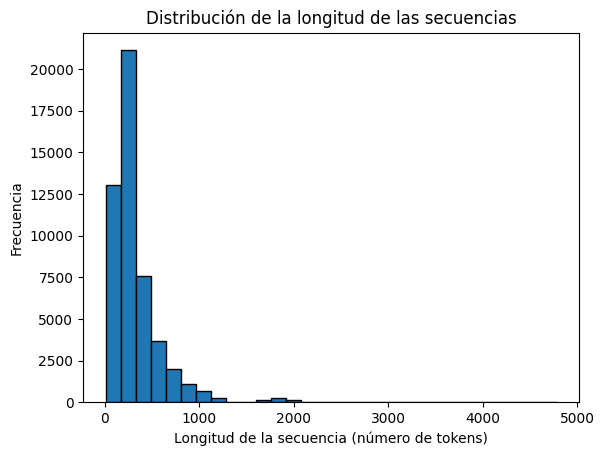

In [11]:
import matplotlib.pyplot as plt

texts = df['review_es'].tolist()
lengths = [len(tokenizer.tokenize(text)) for text in texts]

plt.hist(lengths, bins=30, edgecolor='black')
plt.xlabel('Longitud de la secuencia (número de tokens)')
plt.ylabel('Frecuencia')
plt.title('Distribución de la longitud de las secuencias')
plt.show()

# Hacemos pruebas con el tokenizador y encoding

In [12]:
# Ejemplo tokenización
sample_txt = 'Una pequeña pequeña producción.La técnica de'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print('Frase: ', sample_txt)
print('Tokens: ', tokens)
print('Tokens numéricos: ', token_ids)

Frase:  Una pequeña pequeña producción.La técnica de
Tokens:  ['Una', 'pequeña', 'pequeña', 'producción', '.', 'La', 'técnica', 'de']
Tokens numéricos:  [1965, 4015, 4015, 3109, 1009, 1198, 4541, 1008]


In [13]:
# Codificación para introducir a BERT
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length = 10,
    truncation = True,
    add_special_tokens = True,
    return_token_type_ids = False,
    padding=True,
    return_attention_mask = True,
    return_tensors = 'pt'
)

In [14]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [15]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))
print(encoding['input_ids'][0])
print(encoding['attention_mask'][0])

['[CLS]', 'Una', 'pequeña', 'pequeña', 'producción', '.', 'La', 'técnica', 'de', '[SEP]']
tensor([   4, 1965, 4015, 4015, 3109, 1009, 1198, 4541, 1008,    5])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


# Definimos el limite maximo de tokens que tiene el modelo y lo ajustamos al dataset

In [16]:
max_input_length = tokenizer.model_max_length

print(max_input_length)

def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    return tokens

512


# Incializamos las variables para separar test/train, el tamaño maximo del token, tamaño del batch, y los sentimientos

In [17]:
import numpy as np

RANDOM_SEED = 42
MAX_LEN = max_input_length
BATCH_SIZE = 16
NCLASSES = 2

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Creamos la clase Dataset

In [18]:
# CREACIÓN DATASET
from torch.utils.data import Dataset, DataLoader

class IMDBDataset(Dataset):

  def __init__(self,reviews,labels,tokenizer,max_len):
    self.reviews = reviews
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
      return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    label = self.labels[item]
    encoding = tokenizer.encode_plus(
        review,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        padding = True,
        return_attention_mask = True,
        return_tensors = 'pt'
        )

    return {
          'review': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      }

# Definimos el collate para el dataloader

In [19]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    labels = [item['label'] for item in batch]

    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    labels = torch.tensor(labels, dtype=torch.long)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks,
        'labels': labels
    }

# Definimos el dataloader

In [20]:
# Data loader:
def data_loader(df, tokenizer, max_len, batch_size, collate_fn):
  dataset = IMDBDataset(
      reviews = df.review_es.to_numpy(),
      labels = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = MAX_LEN
  )

  return DataLoader(dataset, batch_size = BATCH_SIZE, collate_fn=collate_fn, num_workers = 4)

# Separamos el dataset y creamos el train/test para el entrenamiento

In [21]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size = 0.2, random_state=RANDOM_SEED)

train_data_loader = data_loader(df_train, tokenize_and_cut, MAX_LEN, BATCH_SIZE, collate_fn)
test_data_loader = data_loader(df_test, tokenize_and_cut, MAX_LEN, BATCH_SIZE, collate_fn)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Verificamos que el formato de los datos esten correctos sacando un ejemplo

In [22]:
for batch in train_data_loader:
    print(batch)
    break

{'input_ids': tensor([[    4,  1791,  1058,  ...,  1184,  1062,     5],
        [    4,  1125,  1235,  ...,     1,     1,     1],
        [    4,  1965,  2653,  ...,     1,     1,     1],
        ...,
        [    4,  1162, 24755,  ...,  1049,  9246,     5],
        [    4,  1125,  1847,  ...,     1,     1,     1],
        [    4,  1965,  3598,  ...,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0])}


# Importamos las librerias para el entrenamiento y para descargar el modelo BETO

In [23]:
from transformers import AdamW, get_linear_schedule_with_warmup
from torch import nn, optim
from textwrap import wrap

In [24]:
from transformers import BertModel

# Creamos el modelo

In [25]:
class BETOsentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BETOsentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
    self.drop = nn.Dropout(p=0.3)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask,
    )
    #print(outputs)
    cls_output = outputs[1]  # Get the CLS token output
    cls_output = torch.tensor(cls_output)  # Convert to Tensor
    drop_output = self.drop(cls_output)
    output = self.linear(drop_output)
    return output

In [26]:
model = BETOsentimentClassifier(NCLASSES)
model = model.to(device)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Definimos el optimizador, steps, scheduler y el criterio para el entrenamiento

In [27]:
# ENTRENAMIENTO
EPOCHS = 7
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Empezamos a entrenarlo

In [28]:
# Iteración entrenamiento
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for batch in data_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double()/n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)
      outputs = model(input_ids = input_ids, attention_mask = attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double()/n_examples, np.mean(losses)

for epoch in range(EPOCHS):
  print('Epoch {} de {}'.format(epoch+1, EPOCHS))
  print('------------------')
  train_acc, train_loss = train_model(
      model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
  )
  test_acc, test_loss = eval_model(
      model, test_data_loader, loss_fn, device, len(df_test)
  )
  print('Entrenamiento: Loss: {}, accuracy: {}'.format(train_loss, train_acc))
  print('Validación: Loss: {}, accuracy: {}'.format(test_loss, test_acc))
  print('')

Epoch 1 de 7
------------------
Entrenamiento: Loss: 0.6141103160023689, accuracy: 0.7028500000000001
Validación: Loss: 0.5619160556316376, accuracy: 0.7689

Epoch 2 de 7
------------------
Entrenamiento: Loss: 0.5601703528761863, accuracy: 0.747175
Validación: Loss: 0.5264274631500244, accuracy: 0.7762

Epoch 3 de 7
------------------
Entrenamiento: Loss: 0.5344635969638825, accuracy: 0.760675
Validación: Loss: 0.5063056874275208, accuracy: 0.7795000000000001

Epoch 4 de 7
------------------
Entrenamiento: Loss: 0.5200301772713661, accuracy: 0.7644000000000001
Validación: Loss: 0.49432169971466067, accuracy: 0.783

Epoch 5 de 7
------------------
Entrenamiento: Loss: 0.5136244153022766, accuracy: 0.7653500000000001
Validación: Loss: 0.48713965911865237, accuracy: 0.7848

Epoch 6 de 7
------------------
Entrenamiento: Loss: 0.5071693784713746, accuracy: 0.769225
Validación: Loss: 0.48311324944496153, accuracy: 0.786

Epoch 7 de 7
------------------
Entrenamiento: Loss: 0.50505493944883

# Definimos la prediccion de sentimiento y le damos un texto de prueba

In [29]:
def classifySentiment(review_text):
  encoding_review = tokenizer.encode_plus(
      review_text,
      max_length = MAX_LEN,
      truncation = True,
      add_special_tokens = True,
      return_token_type_ids = False,
      padding = True,
      return_attention_mask = True,
      return_tensors = 'pt'
      )

  input_ids = encoding_review['input_ids'].to(device)
  attention_mask = encoding_review['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  print("\n".join(wrap(review_text)))
  if prediction:
    print('Positivo')
  else:
    print('Negativo')

In [30]:
review_text = "La película es muy buena  me gusta el drama que tiene y la historia en la que fue basada"
classifySentiment(review_text)
review_text = "La película es muy mala no me gusta el drama que tiene y la historia en la que fue basada"
classifySentiment(review_text)

La película es muy buena  me gusta el drama que tiene y la historia en
la que fue basada
Positivo
La película es muy mala no me gusta el drama que tiene y la historia
en la que fue basada
Negativo
